In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
from keras import regularizers
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem.porter import *
import nltk
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to /home/mark/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mark/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
train = pd.read_csv('../train.csv')

In [3]:
import re
import string
def clean(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    
    stp = set(stopwords.words("english"))
    st = WordNetLemmatizer()
    stemmer = PorterStemmer()
    text = text.split()
    text = [w for w in text if not w in stp]
    text = [st.lemmatize(w) for w in text]
    text = [stemmer.stem(word) for word in text if len(word)>3]
    text = " ".join(text)

    text = text.translate(str.maketrans("", "", string.punctuation))
    return text

train['text'] = train.text.apply(lambda x: clean(x))

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train['text'], train['target'], test_size=0.3, random_state=42)

In [ ]:
import tensorflow_hub as hub

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embedded = hub.KerasLayer(module_url, trainable=False, name='USE_embeddedding')

In [6]:
def build_model(embedded):
    model = Sequential()
    model.add(Input(shape=[], dtype=tf.string))
    model.add(embedded)
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.03)))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.05)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [7]:
model = build_model(embedded)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE_embeddedding (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 1)               

In [8]:
checkpoint = ModelCheckpoint('weights.best.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [9]:
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=15, 
                    callbacks=[checkpoint, reduce_lr], batch_size=16)

Train on 5329 samples, validate on 2284 samples
Epoch 1/15
5232/5329 [============================>.] - ETA: 0s - loss: 4.9619 - accuracy: 0.7471
Epoch 00001: val_accuracy improved from -inf to 0.60902, saving model to weights.best.hdf5
5329/5329 [==============================] - 11s 2ms/sample - loss: 4.9019 - accuracy: 0.7478 - val_loss: 1.8118 - val_accuracy: 0.6090
Epoch 2/15
5232/5329 [============================>.] - ETA: 0s - loss: 1.0310 - accuracy: 0.7695
Epoch 00002: val_accuracy improved from 0.60902 to 0.77627, saving model to weights.best.hdf5
5329/5329 [==============================] - 8s 1ms/sample - loss: 1.0251 - accuracy: 0.7690 - val_loss: 0.7169 - val_accuracy: 0.7763
Epoch 3/15
5280/5329 [============================>.] - ETA: 0s - loss: 0.6444 - accuracy: 0.7708
Epoch 00003: val_accuracy improved from 0.77627 to 0.77671, saving model to weights.best.hdf5
5329/5329 [==============================] - 10s 2ms/sample - loss: 0.6450 - accuracy: 0.7698 - val_loss: 0.

In [10]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 76.97%


In [11]:
model.predict(X_test)

array([[0.04693749],
       [0.06535044],
       [0.00838841],
       ...,
       [0.99726665],
       [0.9985415 ],
       [0.77814883]], dtype=float32)

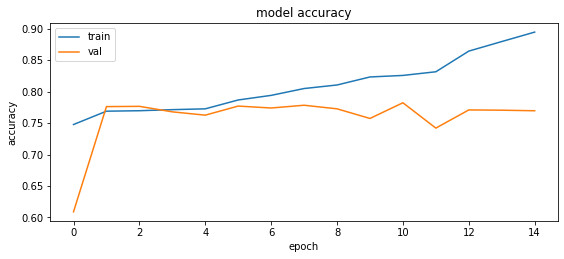

In [12]:
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')